### Connection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory analysis

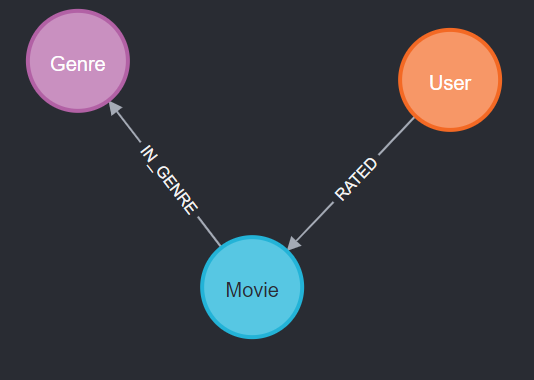

Graph features:
- Directed
- Acyclic
- Unweighted for genre relation and Weighted for rating relation
- Sparse (|edge|<100M)

- todo: system constraints and index in classical and new import
- check for import startup (è meglio creare prima il db, con constraints e indici oppure farlo dopo)
- exploratory analysis normale
- graph analytics con grafi e nodi che aggiungi
- guarda i link della prof e esempi simili
- usa chat gpt

### Distributions of data

<Axes: title={'center': 'Occupation distribution'}, ylabel='count'>

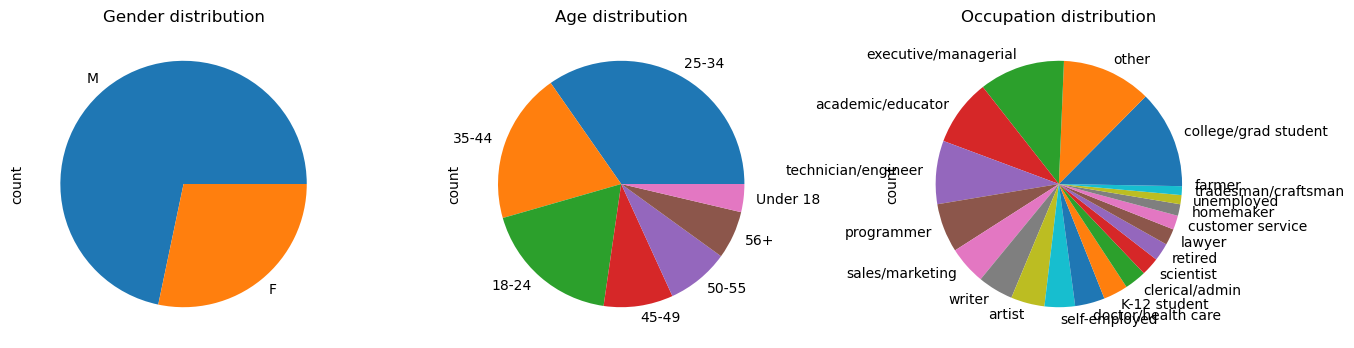

In [3]:
occupation_labels = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}
age_labels = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+",
}
users = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.gender as gender,u.age as age,u.occupation as occupation;
"""
)
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
users["gender"].value_counts().plot(kind="pie", ax=ax[0], title="Gender distribution")
users_age = users["age"].value_counts()
users_age = users_age.rename(index=age_labels)
users_age.plot(kind="pie", color="skyblue", title="Age distribution", ax=ax[1])
users_occupation = users["occupation"].value_counts()
users_occupation = users_occupation.rename(index=occupation_labels)
users_occupation.plot(kind="pie", title="Occupation distribution", ax=ax[2])

<Axes: >

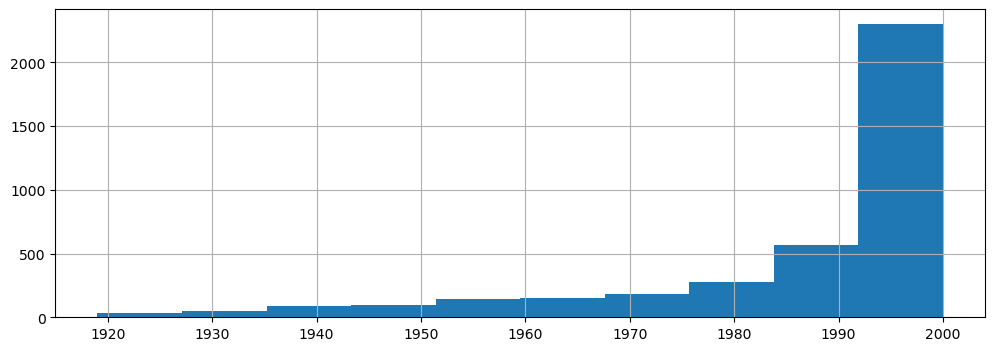

In [4]:
movies = gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title as title,m.year as year;
"""
)
movies["year"].hist(figsize=(12, 4))

<Axes: xlabel='genre'>

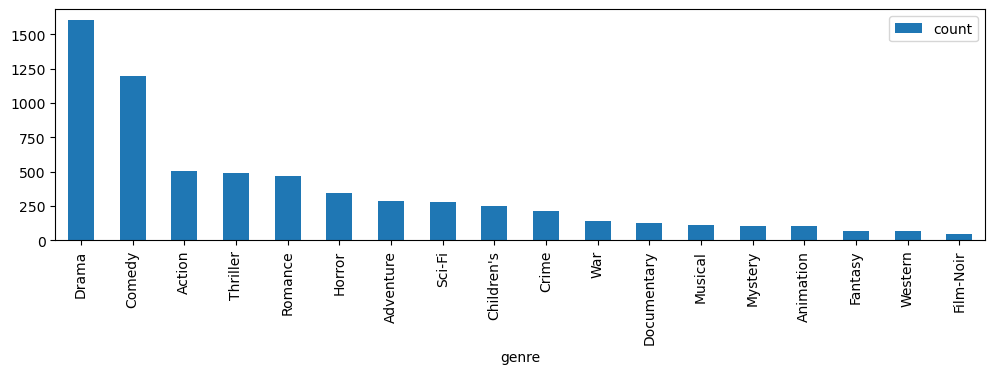

In [5]:
movies_per_genre_distributions = gds.run_cypher(
    """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    RETURN g.name as genre, COUNT(m) as count
    ORDER BY count DESC;
"""
)
movies_per_genre_distributions.plot(kind="bar", x="genre", y="count", figsize=(12, 3))

<Axes: xlabel='rating'>

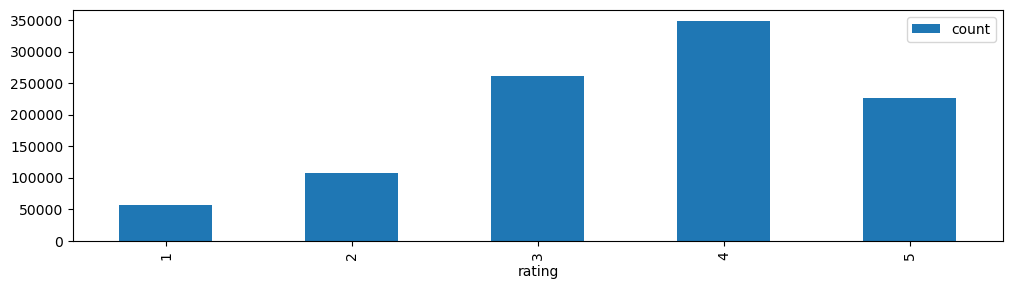

In [6]:
ratings_vote_distribution = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, COUNT(*) as count
    ORDER BY rating;
"""
)
ratings_vote_distribution.plot(kind="bar", x="rating", y="count", figsize=(12, 3))

<Axes: xlabel='year'>

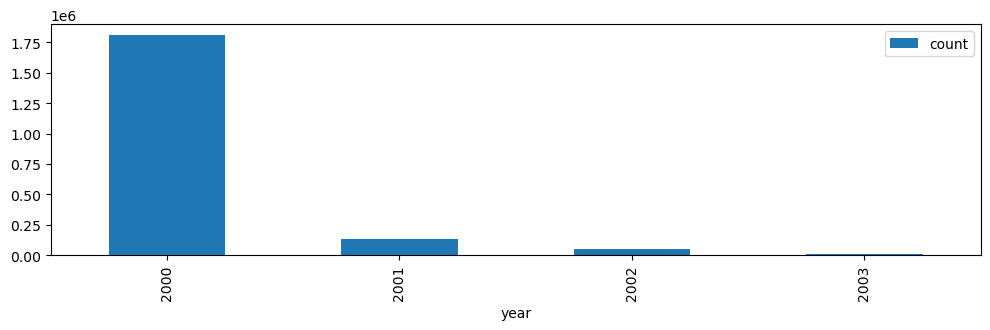

In [7]:
ratings_year_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.year as year, COUNT(*) as count
    ORDER BY year;

"""
)
ratings_year_distribution.plot(kind="bar", x="year", y="count", figsize=(12, 3))

<Axes: xlabel='month'>

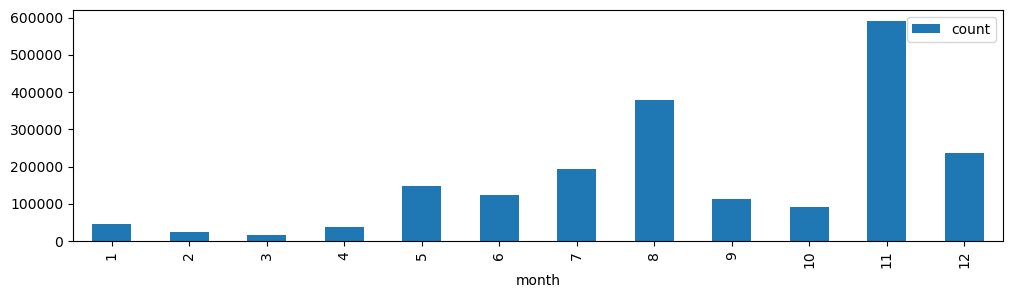

In [8]:
ratings_month_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.month as month, COUNT(*) as count
    ORDER BY month;

"""
)
ratings_month_distribution.plot(kind="bar", x="month", y="count", figsize=(12, 3))

So to `summarise` these graphs:  
- The users are mostly `male`, `young` (18-44 years old) from different employment sectors (small majority of students and academic people).  
- Most of the films were made between the `1990s` and `2000s`, they are part of the `drama` and `comedy` genre.  
- Most of the reviews are `positive` with a prevalence of a rating of `4`.  
- The ratings were almost all made in the year `2000` and mostly around the months of `November` and `December` (`August` and `July` also has a good frequency) 

### Creation of general graph projections
First of all it be created some graph projection for starting exploration of data.  
- 'movies-graph' with all data
- 'movies-users' with all connection (:User)-[:RATED]->(:Movie)
- 'movies-genres' with all connection (:Movie)-[:IN_GENRE]->(:Genre)

In [9]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-full',
    ['User', 'Movie', 'Genre'],
    ['RATED', 'IN_GENRE']
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-full,"{'User': {'label': 'User', 'properties': {}}, ...",9941,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",1006617


In [10]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-rates',
    ['Movie','User'],
    {
        RATED:{properties:['rating','month','year']}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)

In [11]:
result = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)-[:IN_GENRE]->(g:Genre)
    WITH gds.graph.project('users-genres', u, g,{relationshipProperties:r{.rating}}) AS g
    RETURN
    g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
"""
)
result

,graph,nodes,rels
0,users-genres,6058,2101815


## Connectivity Analysis

### Global connectivity
We have no informations about relations of users, so it's useless calculate diameter.  
The graph structure is in general weakly connected so we can do a global analysis of the weakly connected components and see if there are any distinct groups in the network.

In [12]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-full")
    YIELD componentCount
    """
).componentCount[0]
print(f"In general graph there's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("users-rates")
    YIELD componentCount
    """
).componentCount[0]
print(f"But in users-rates graph ther're {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stream("users-rates")
    YIELD nodeId, componentId
    RETURN nodeId AS title, componentId
    ORDER BY componentId, title
    """
)
unique_results = result.nunique()
print(
    f"Uniques values of WCC: {unique_results.title} elements in {unique_results.componentId} groups"
)
unique_results = result[result["componentId"] > 0].nunique()
print(
    f"Uniques values of WCC without first group: {unique_results.title} elements in {unique_results.componentId} groups"
)
print(
    f"So {unique_results.componentId} with 1 node for each groups (excluding the first one)"
)
print(
    "This maybe is caused because there are 177 movies that haven't any rating (this will be confirmed later)"
)

In general graph there's 1 weakly connected component.
But in users-rates graph ther're 178 weakly connected component.
Uniques values of WCC: 9923 elements in 178 groups
Uniques values of WCC without first group: 177 elements in 177 groups
So 177 with 1 node for each groups (excluding the first one)
This maybe is caused because there are 177 movies that haven't any rating (this will be confirmed later)


In this first global analysis we can say that the graph is a single groups of weakly connected components with 177 movies that we can't consider in the analysis.  



### Local connectivity
Now it can be see the density and its degree distribution stats.  
This graph was chosen because of its higher density compared with the other datasets available on grouplens 

In [13]:
result = gds.run_cypher(
    """
    CALL gds.graph.list('movies-full')
    YIELD density,degreeDistribution
"""
)
print(f"Density: {result['density'][0]}")
print(f"Degree distribution: {result['degreeDistribution'][0]}")

Density: 0.010187035096607205
Degree distribution: {'min': 0, 'max': 2314, 'p90': 295, 'p999': 1286, 'p99': 825, 'p50': 35, 'p75': 123, 'p95': 442, 'mean': 101.25912886027562}


#### Write some properties to nodes

In [49]:
gds.run_cypher(
    """CALL gds.degree.write('users-rates', {writeProperty: 'outDegree' })"""
)
gds.run_cypher(
    """CALL gds.degree.write('users-rates', {orientation:'REVERSE', writeProperty: 'inDegree' })"""
)

gds.run_cypher(
    """
    MATCH (u:User)
    SET u.ratings = toInteager(u.outDegree)
    REMOVE u.inDegree, u.outDegree;
    """
)

gds.run_cypher(
    """
    MATCH (m:Movie)
    SET m.ratings = toInteger(m.inDegree)
    REMOVE m.inDegree, m.outDegree;
    """
)

""


In [46]:
# Check if there are movies and users without ratings
movies_without_ratings = gds.run_cypher(
    """
    MATCH (m:Movie WHERE m.ratings = 0)
    RETURN COUNT(m) as count;
"""
)["count"][0]
users_without_ratings = gds.run_cypher(
    """
    MATCH (u:User WHERE u.ratings = 0)
    RETURN COUNT(u) as count;
"""
)["count"][0]
print(f"There are {movies_without_ratings} movies without ratings")
print(f"There are {users_without_ratings} users without ratings")

There are 177 movies without ratings
There are 0 users without ratings


Analyzing the degree distribution of the nodes, we can say that the distribution behaves like that of pareto.

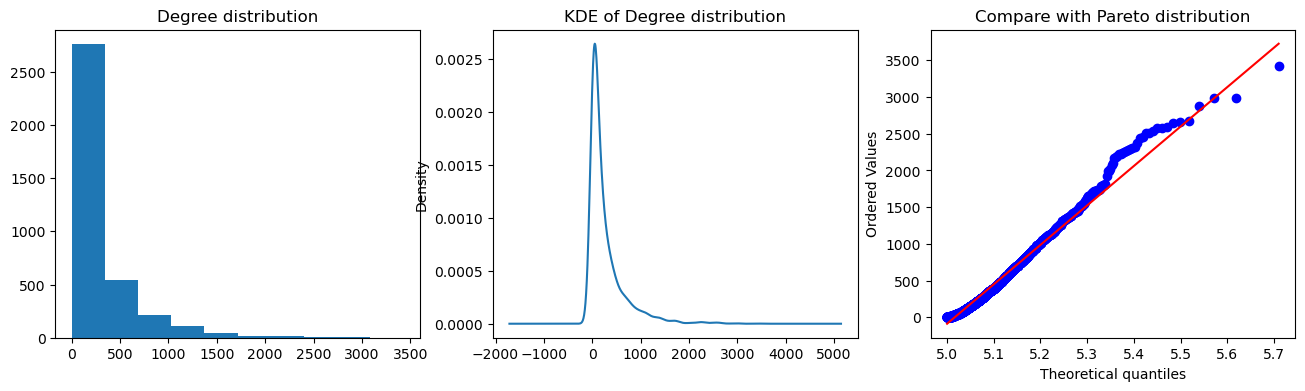

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: ratings, dtype: float64

In [39]:
result = gds.run_cypher(
    """
    MATCH (m:Movie WHERE m.ratings>0)
    RETURN m.title as title,m.ratings as ratings
    ORDER BY ratings DESC
    """
)
movies_degree = result["ratings"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(movies_degree, bins=10)
ax[0].set_title("Degree distribution")
movies_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(movies_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
movies_degree.describe()

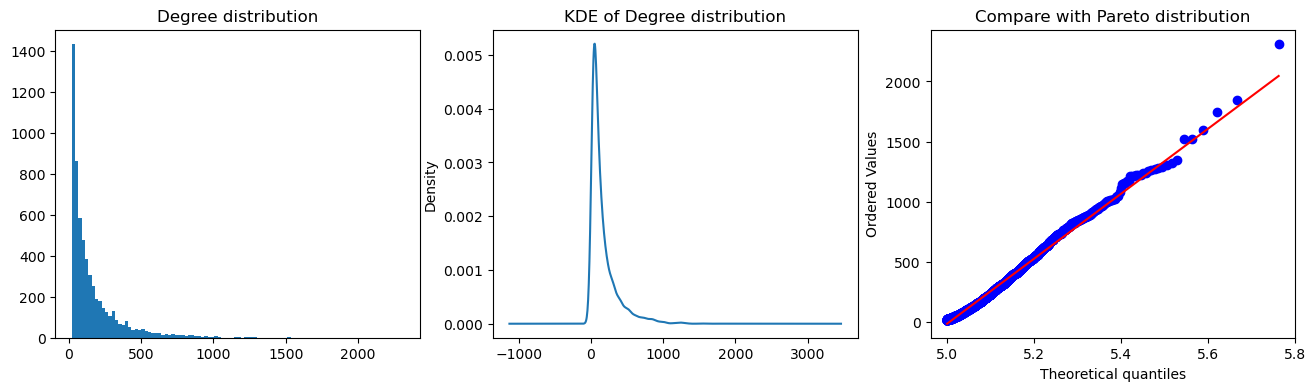

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: ratings, dtype: float64

In [43]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.title as title,u.ratings as ratings
    ORDER BY ratings DESC
    """
)
users_degree = result["ratings"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(users_degree, bins=100)
ax[0].set_title("Degree distribution")
users_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(users_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
users_degree.describe()

Text(0.5, 1.0, 'Boxplot of Users degree distribution')

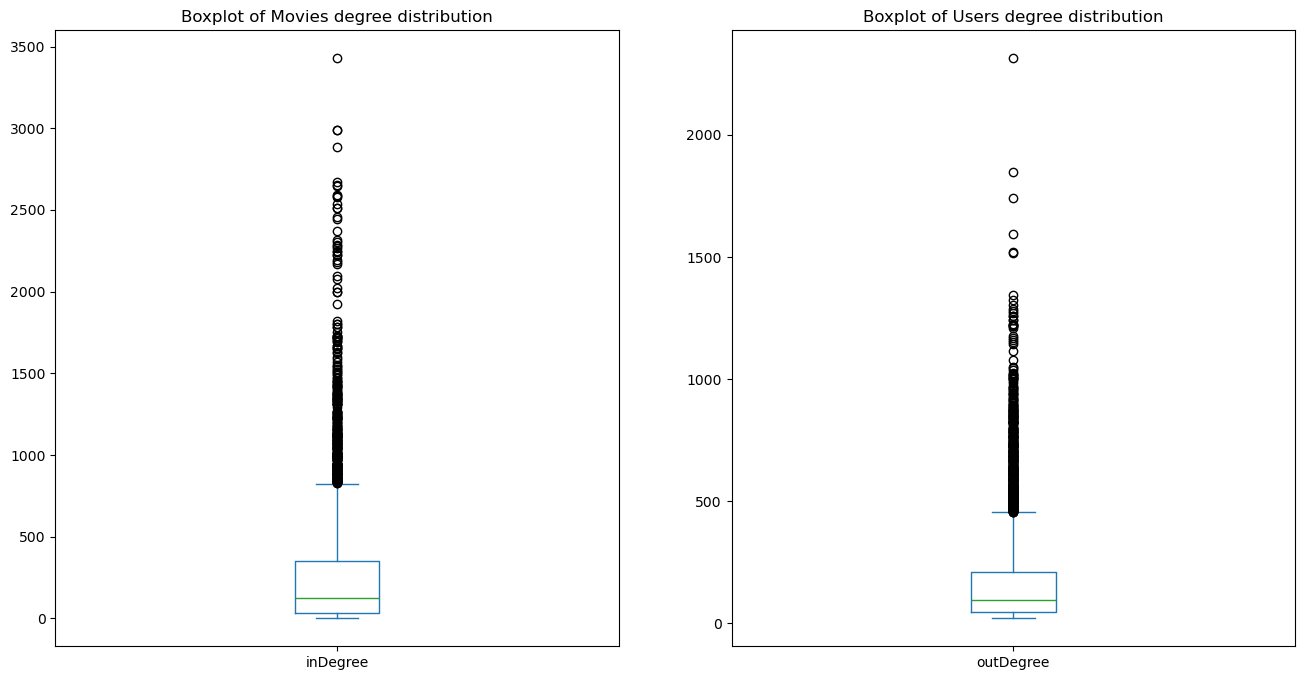

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
movies_degree.plot.box(ax=ax[0])
ax[0].set_title("Boxplot of Movies degree distribution")
users_degree.plot.box(ax=ax[1])
ax[1].set_title("Boxplot of Users degree distribution")

#### top 10 movies with the most reviews

In [50]:
gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title AS title, m.ratings AS ratings
    ORDER BY ratings DESC, title  DESC
    LIMIT 10
"""
)

,title,ratings
0,American Beauty (1999),3428
1,Star Wars: Episode IV - A New Hope (1977),2991
2,Star Wars: Episode V - The Empire Strikes Back...,2990
3,Star Wars: Episode VI - Return of the Jedi (1983),2883
4,Jurassic Park (1993),2672
5,Saving Private Ryan (1998),2653
6,Terminator 2: Judgment Day (1991),2649
7,Matrix The (1999),2590
8,Back to the Future (1985),2583
9,Silence of the Lambs The (1991),2578


#### top 10 users with the most reviews

In [51]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.userId as id,u.gender AS gender, u.age AS age, u.occupation AS occupation, u.ratings AS ratings
    ORDER BY ratings DESC
    LIMIT 10
"""
)
result["age"] = result["age"].map(age_labels)
result["occupation"] = result["occupation"].map(occupation_labels)
result

,id,gender,age,occupation,ratings
0,4169,M,50-55,other,2314
1,1680,M,25-34,writer,1850
2,4277,M,35-44,self-employed,1743
3,1941,M,35-44,technician/engineer,1595
4,1181,M,35-44,executive/managerial,1521
5,889,M,45-49,writer,1518
6,3618,M,56+,technician/engineer,1344
7,2063,M,25-34,college/grad student,1323
8,1150,F,25-34,writer,1302
9,1015,M,35-44,clerical/admin,1286


#### Analyze an user in depth

In [31]:
result = gds.run_cypher(
    """
    MATCH (u:User{userId:4169})-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, r.year as year,r.month as month, m.movieId as movieId
    """
)

array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'movieId'}>]], dtype=object)

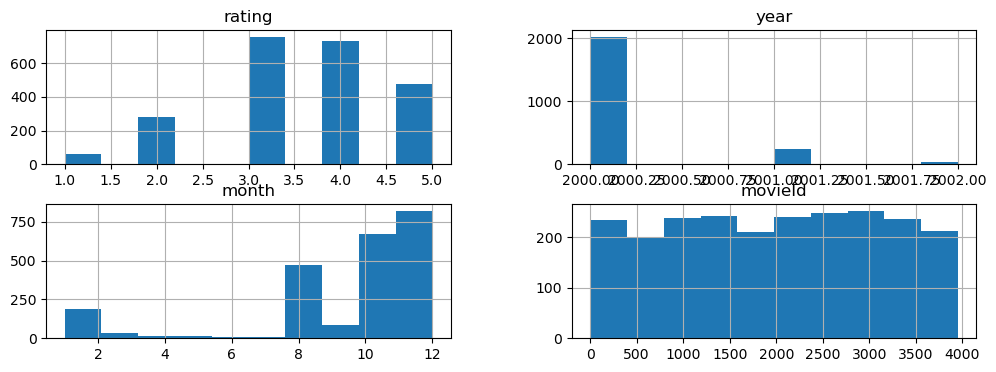

In [32]:
result.hist(figsize=(12, 4))

In [33]:
app = result["movieId"].value_counts()
app[app > 1]

Series([], Name: count, dtype: int64)

<Axes: ylabel='count'>

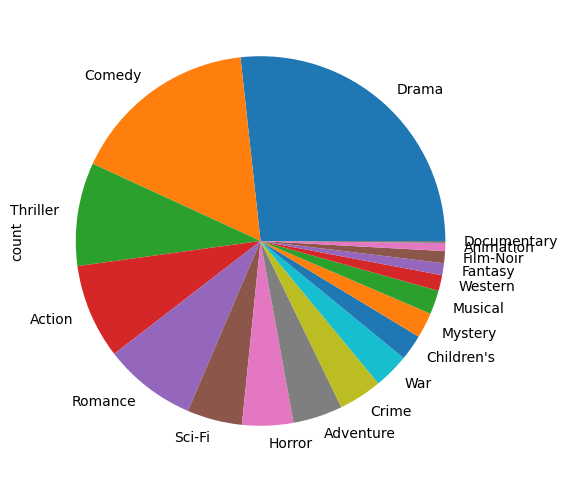

In [ ]:
result["genre"].value_counts().plot(kind="pie", figsize=(6, 6))

## Add nodes property information

#### on Gender node

In [61]:
gds.run_cypher(
    """CALL gds.degree.write('users-genres', {orientation:'REVERSE', writeProperty: 'inDegree' })"""
)

gds.run_cypher(
    """
    MATCH (u:User)
    REMOVE u.inDegree;
    """
)

gds.run_cypher(
    """
    MATCH (g:Genre)
    SET g.ratings = toInteger(g.inDegree)
    REMOVE g.inDegree;
    """
)

""


In [64]:
gds.run_cypher(
    """
    MATCH (g:Genre)
    RETURN g.name as name, g.ratings as ratings
    ORDER BY ratings DESC
    """
)

,name,ratings
0,Comedy,356580
1,Drama,354529
2,Action,257457
3,Thriller,189680
4,Sci-Fi,157294
5,Romance,147523
6,Adventure,133953
7,Crime,79541
8,Horror,76386
9,Children's,72186


#### on User

In [2]:
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED WHERE r.rating>3]->(:Movie)-[:IN_GENRE]->(g:Genre) 
        RETURN g.genreId AS genreId, COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 3
    }
    MATCH (u:User WHERE u.userId = userId)
    MATCH (g:Genre WHERE g.genreId = genreId)
    MERGE (u)-[l:LIKES]->(g)
    SET l.score = count
    """
)

""


In [11]:
# Set favorite genre for each user
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED WHERE r.rating>3]->(:Movie)-[:IN_GENRE]->(g:Genre) 
        RETURN g.genreId AS genreId,g.name AS genre, COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (u:User WHERE u.userId = userId)
    SET u.favoriteGenreId = genreId
    RETURN userId, u.favoriteGenre, count
    """
)

,userId,u.favoriteGenre,count
0,1,1,21
1,2,1,52
2,3,7,21
3,4,3,16
4,5,1,42
...,...,...,...
6033,6036,1,212
6034,6037,1,65
6035,6038,2,8
6036,6039,2,42


In [8]:
gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(:Movie)
    WITH u.userId as userId, AVG(r.rating) as avgRating, STDEV(r.rating) as stdRating, MIN(r.rating) as minRating, MAX(r.rating) as maxRating
    MATCH (u:User WHERE u.userId = userId)
    SET u.avgRating = toInteger(avgRating), u.stdRating = toInteger(stdRating), u.minRating = minRating, u.maxRating = maxRating
    RETURN userId, u.avgRating, u.stdRating, minRating, maxRating
    ORDER BY userId
    """
)

,userId,avgRating,stdRating,minRating,maxRating
0,1,4.188679,0.680967,3,5
1,2,3.713178,1.001513,1,5
2,3,3.901961,0.984985,1,5
3,4,4.190476,1.077917,1,5
4,5,3.146465,1.132699,1,5
...,...,...,...,...,...
6035,6036,3.302928,1.023684,1,5
6036,6037,3.717822,0.877910,1,5
6037,6038,3.800000,1.105013,1,5
6038,6039,3.878049,0.730881,2,5


In [132]:
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED WHERE r.rating>3]->(:Movie) 
        RETURN r.year as year,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (u:User WHERE u.userId = userId)
    SET u.favoriteYear = year
    RETURN userId, year, count
    """
)

,userId,year,count
0,1,2000,34
1,2,2000,73
2,3,2000,37
3,4,2000,18
4,5,2000,82
...,...,...,...
6033,6036,2000,399
6034,6037,2000,120
6035,6038,2000,13
6036,6039,2000,90


In [133]:
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED WHERE r.rating>3]->(:Movie) 
        RETURN r.month as month,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (u:User WHERE u.userId = userId)
    SET u.favoriteMonth = month
    RETURN userId, month, count
    """
)

,userId,month,count
0,1,12,34
1,2,12,73
2,3,12,37
3,4,12,18
4,5,12,82
...,...,...,...
6033,6036,4,399
6034,6037,4,120
6035,6038,4,13
6036,6039,4,90


#### on Movie

In [6]:
a = gds.run_cypher(
    """
    MATCH (:User)-[r:RATED]->(m:Movie)
    WITH m, AVG(r.rating) as avgRating, STDEV(r.rating) as stdRating, MIN(r.rating) as minRating, MAX(r.rating) as maxRating
    MATCH (m:Movie WHERE m.movieId = m.movieId)
    SET m.avgRating = toInteger(avgRating), m.stdRating = toInteger(stdRating), m.minRating = minRating, m.maxRating = maxRating
    RETURN m.movieId, m.avgRating, m.stdRating, minRating, maxRating
    ORDER BY m.movieId
    """
)

In [7]:
a

,m.movieId,m.avgRating,m.stdRating,minRating,maxRating
0,1,4,0,1,5
1,2,3,0,1,5
2,3,3,1,1,5
3,4,2,1,1,5
4,5,3,1,1,5
...,...,...,...,...,...
3701,3948,3,1,1,5
3702,3949,4,1,1,5
3703,3950,3,1,1,5
3704,3951,3,1,1,5


In [135]:
gds.run_cypher(
    """
    MATCH (m:Movie) 
    WITH m.movieId AS movieId
    CALL {
        WITH movieId
        MATCH (:User)-[r:RATED WHERE r.rating>3]->(m:Movie WHERE m.movieId = movieId) 
        RETURN r.year as year,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (m:Movie WHERE m.movieId = movieId)
    SET m.favoriteYear = year
    RETURN movieId, year, count
    """
)

,movieId,year,count
0,1,2000,1567
1,2,2000,263
2,3,2000,142
3,4,2000,35
4,5,2000,84
...,...,...,...
3528,3948,2000,384
3529,3949,2000,105
3530,3950,2002,13
3531,3951,2000,18


In [136]:
gds.run_cypher(
    """
    MATCH (m:Movie) 
    WITH m.movieId AS movieId
    CALL {
        WITH movieId
        MATCH (:User)-[r:RATED WHERE r.rating>3]->(m:Movie WHERE m.movieId = movieId) 
        RETURN r.month as month,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (m:Movie WHERE m.movieId = movieId)
    SET m.favoriteMonth = month
    RETURN movieId, month, count
    """
)

,movieId,month,count
0,1,11,512
1,2,11,71
2,3,11,65
3,4,7,7
4,5,11,31
...,...,...,...
3528,3948,11,252
3529,3949,11,73
3530,3950,11,6
3531,3951,11,14


In [16]:
gds.run_cypher(
    """
    MATCH (u:User) 
    SET u.binaryGender = CASE WHEN u.gender='F' THEN 1 ELSE 0 END
    """
)

""


- sistema questo file
- pulisci la roba della degree e non scrivere se non ti serve dopo
- tieni solo creazioni di grafi utili
- se ti resta tempo fai contingesy table qui e poi tra le community